# Skip-Gram Model

In [1]:
import os
import random
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Set Helpers

In [3]:
from types import SimpleNamespace

In [4]:
def generate_negative_samples(target_index, index_range, k):
    
    random_index = random.sample(index_range, 6)
    
    return SimpleNamespace(
                target=word2idx[words[target_index]],
                context=[word2idx[word] for word in [words[index] for index in random_index]],
                label=0,
    )

In [5]:
def text_to_data(words, context_window=2, k=6):
    
    positives = []
    negatives = []
    
    context_range = range(-context_window, context_window+1)
    for current_index in range(context_window, len(words) - context_window):
        
        # positive samples
        for relative_index in context_range:
            if current_index + relative_index != current_index:
                positives.append(SimpleNamespace(
                    target=word2idx[words[current_index]],
                    context=word2idx[words[current_index+relative_index]],
                    label=1,
                ))
                
        # negative samples
        for _ in context_range:
            
            rand = random.random()
            
            lhs_index_range = None
            rhs_index_range = None
            
            # select from lhs of target
            if (current_index - context_window - 2*k) > 0:
                # this also accounts for the fact that there should be samples on the LHS to select from
                lhs_index_range = range(0, current_index - context_window)
                
            if (current_index + context_window + 2*k) < len(words):
                # if random value is >= 0.5 or there are not enough samples on the LHS
                rhs_index_range = range(current_index + context_window, len(words))
                
            if lhs_index_range and rhs_index_range:
                index_range = random.choice([lhs_index_range, rhs_index_range])
            elif lhs_index_range:
                index_range = lhs_index_range
            else:
                index_range = rhs_index_range
                
            negatives.append(
                generate_negative_samples(current_index, index_range, k)
            )
            
    return positives, negatives

In [6]:
def data_to_tensor(data, dtype=torch.LongTensor):
    
    tensor = dtype(data)
    
    if device.type == 'cuda':
        tensor = tensor.cuda()
        
    return Variable(tensor)

In [7]:
def unpack_data_point(data_point):
    return data_point.target, data_point.context, data_point.label

## Load Corpus

In [8]:
corpus = """
As the eight strange beings applauded, one of them even cupping a hand over her lipsticked mouth to cheer, 
Joel tried to grasp what was happening. The nine of them sat in a fire rimmed cavern around a conference 
table shaped from warm volcanic rock. A chandelier of human bones dangled from the cavern’s ceiling, and it 
rattled around at random like wind chimes. A massive goat-man with reddish-black skin and wicked horns on his 
head towered above the seven others, who flanked him to either side. They looked like pure stereotype. A fat slob 
with sixteen chins, a used car saleman looking guy with gold and silver jewelry all over him, a sultry dominatrix 
in skin tight leather. On the other side a disheveled looking college drop out, a pretty boy staring in a mirror, 
a bald, muscular dude who looked like someone’s pissed off step-dad and a sour faced woman glancing jealously 
around the room. Just where the hell was he? Joel concentrated on his last memory. He remembered highlighting 
pages as his private jet, “The Holy Gust,” flew over the sapphire waters of the Bahamas. He had been reviewing 
his sermon for Sunday – dotting the I’s and crossing the crosses, a little god humor there, praise him – and the 
pilot’s voice had crackled over the intercom about turbulence. Kimberly, his personal assistant, had taken his 
plow out of her mouth and put on her seat belt. The plane had shook and then"""

## Pre-process Corpus

In [9]:
words = word_tokenize(corpus.lower())

In [10]:
vocab = set(words)
word2idx = {word:idx for idx,word in enumerate(vocab)}
idx2word = {idx:word for idx,word in enumerate(vocab)}

In [11]:
positives, negatives = text_to_data(words, 2)

## Set Configs

In [12]:
LR = 1e-3
N_EPOCHS = 100

vocab_size = len(vocab)
embedding_dim = 300

In [13]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

## Build Skip-Gram Network

In [14]:
class SkipGram(nn.Module):
    
    def __init__(self, input_size, embedding_dim):
        super().__init__()
        
        self.vocab_size = input_size
        
        self.context_embedding_layer = nn.Embedding(self.vocab_size, embedding_dim)
        self.target_embedding_layer = nn.Embedding(self.vocab_size, embedding_dim)
        
    def forward(self, target, positive, negative):

        target_ = self.context_embedding_layer(target)
        positive_ = self.context_embedding_layer(positive)
        negative_ = self.context_embedding_layer(negative)

        
        positive_output = torch.matmul(positive_, torch.t(target_))
        negative_output = torch.matmul(target_, torch.t(-negative_.squeeze()))
        
        return positive_output, negative_output

#### Initialize Skip-Gram Network

In [15]:
sg = SkipGram(vocab_size, embedding_dim)
sg.to(device)

SkipGram(
  (context_embedding_layer): Embedding(172, 300)
  (target_embedding_layer): Embedding(172, 300)
)

## Set Loss Function

In [16]:
def mls_loss(positive, negative):
    loss = -(F.logsigmoid(positive) + F.logsigmoid(negative).sum())
    
    return loss

## Set Optimizer

In [17]:
optimizer = torch.optim.SGD(sg.parameters(), lr=LR)

## Train Skip-Gram Network

In [18]:
print_every = 10
train_losses = []

sg.train()

for epoch in range(N_EPOCHS):
    
    train_loss = 0
    
    for positive, negative in zip(positives, negatives):
        
        target, positive_context, label = unpack_data_point(positive)
        target, negative_context, label = unpack_data_point(negative)
        
        target = data_to_tensor([target])
        positive = data_to_tensor([positive_context])
        negative = data_to_tensor([negative_context])
        
        optimizer.zero_grad()
        positive_output, negative_output = sg(target, positive, negative)
        loss = mls_loss(positive_output, negative_output)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    if epoch%print_every == 0:
        print('Epoch: {}/{}, '.format(epoch, N_EPOCHS),
              'Train Loss: {:.6f}'.format(train_loss))
        
    train_losses.append(train_loss)

Epoch: 0/100,  Train Loss: 73520.869485
Epoch: 10/100,  Train Loss: 33799.945733
Epoch: 20/100,  Train Loss: 19784.661798
Epoch: 30/100,  Train Loss: 13140.836030
Epoch: 40/100,  Train Loss: 9625.401417
Epoch: 50/100,  Train Loss: 7552.186665
Epoch: 60/100,  Train Loss: 6345.511707
Epoch: 70/100,  Train Loss: 5649.721847
Epoch: 80/100,  Train Loss: 5233.532950
Epoch: 90/100,  Train Loss: 4939.417414


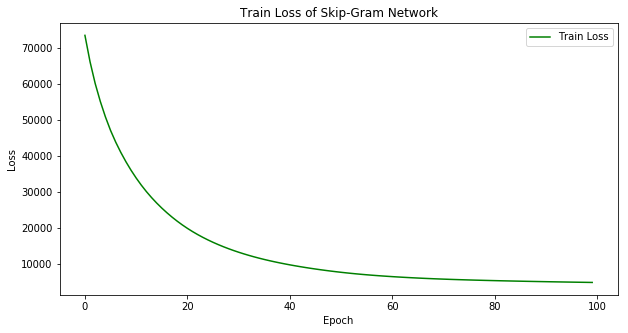

In [19]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Skip-Gram Network")
plt.plot(train_losses, label="Train Loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/Skip_Gram_final_train_loss.png')
plt.show()

## Plot Word Vectors Using PCA

In [20]:
from sklearn.decomposition import PCA

In [21]:
embeds = sg.context_embedding_layer.weight.data
pca = PCA(n_components=2)
embeds_PCA = pca.fit_transform(embeds)

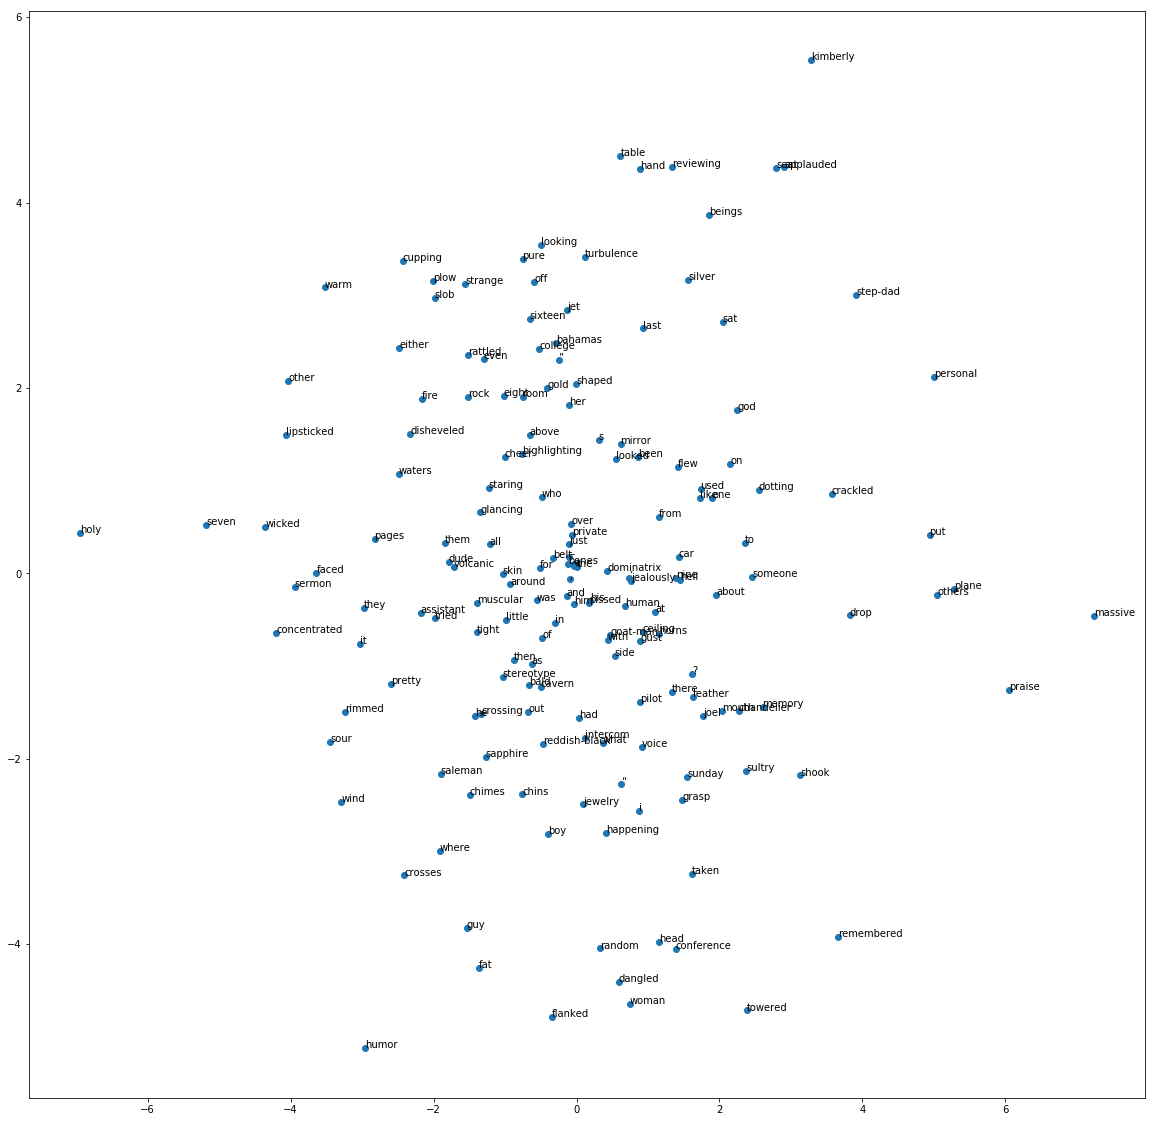

In [22]:
plt.figure(figsize=(20,20))
plt.scatter(embeds_PCA[:, 0], embeds_PCA[:, 1])
words = list(vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(embeds_PCA[i, 0], embeds_PCA[i, 1]))

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/Skip_Gram_PCA_word_vectors.png')
plt.show()

---